In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
path=untar_data(URLs.CAMVID)

In [0]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl=path/'labels'
path_img=path/'images'

In [0]:
fnames=get_image_files(path_img)

In [0]:
fnames[0]

PosixPath('/root/.fastai/data/camvid/images/0016E5_04560.png')

In [0]:
lbl_names=get_image_files(path_lbl)

In [0]:
lbl_names[0]

PosixPath('/root/.fastai/data/camvid/labels/0016E5_05880_P.png')

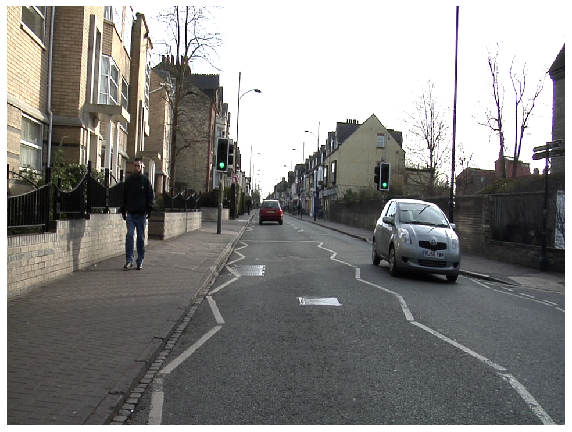

In [0]:
img=open_image(fnames[1])
img.show(figsize=(10,10))

In [0]:
get_y_fn=lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

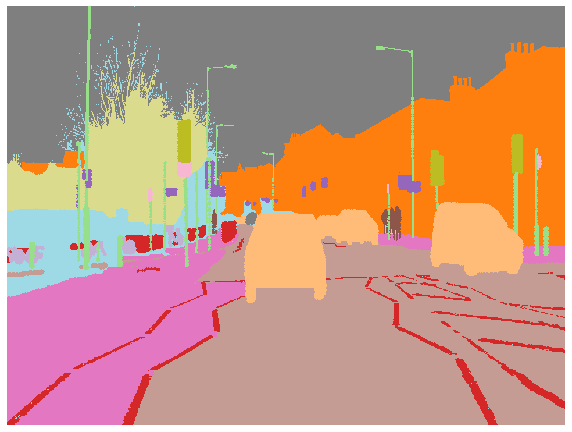

In [0]:
#from fastai.vision import *
img_f=fnames[6]
mask=open_mask(get_y_fn(img_f))
mask.show(figsize=(10,10),alpha=1)

In [0]:
src_size=np.array(mask.shape[1:])
src_size
size=src_size//2;size
bs=2 #batch size
size

array([360, 480])

In [0]:
mask.data

tensor([[[21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         [21, 21, 21,  ..., 21, 21, 21],
         ...,
         [10, 10, 10,  ..., 17, 17, 17],
         [10, 10, 10,  ..., 17, 17, 17],
         [10, 10, 10,  ..., 17, 17, 17]]])

In [0]:
codes=np.loadtxt(path/'codes.txt',dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [0]:

data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_fname_file('/content/data/camvid/valid.txt')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs)
        .normalize(imagenet_stats))
        #Finally -> use the defaults for conversion to databunch

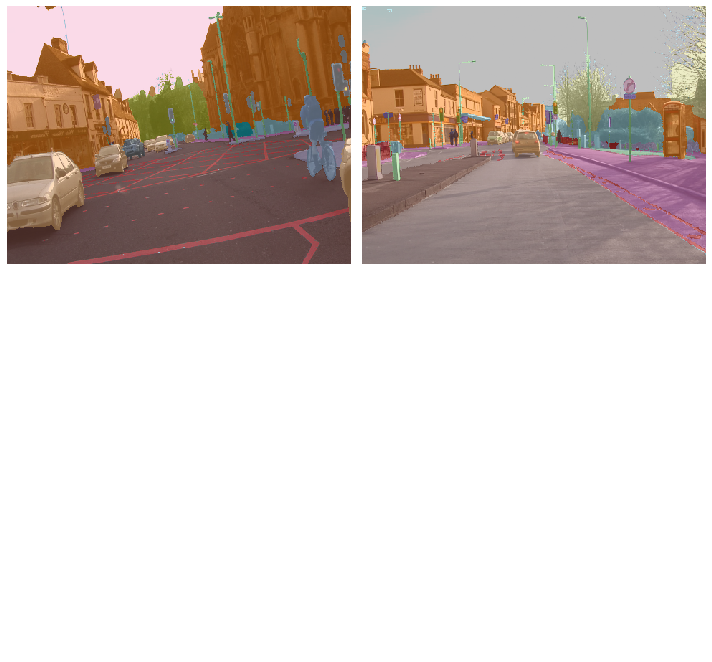

In [0]:
data.show_batch(5,figsize=(10,10))

In [0]:
name2id={v:k for k,v in enumerate(codes)}
name2id
void_code=name2id['Void'] #index of the 'Void' code
void_code
wd=1e-2

In [0]:
def acc_camvid(input, target) :  #input -> original pixel value after segmentation, target -> predicted pixel value
   target=target.squeeze(1)
   mask=(target!=void_code)
   return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid #metrics ==accuracy
learn=unet_learner(data,models.resnet34,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 61.1MB/s]


In [0]:
data.valid_ds

LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images

In [0]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


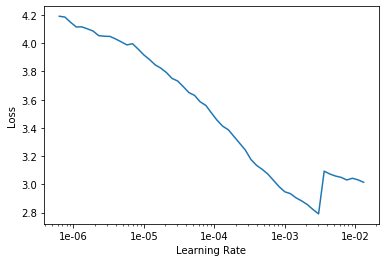

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(10,slice(1e-05,3e-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.991572,0.810076,0.785303,01:01
1,0.814240,0.665463,0.834639,00:58
2,0.657890,0.543823,0.864575,00:58
3,0.560694,0.491287,0.867432,00:58
4,0.492009,0.416905,0.879936,00:58
5,0.411872,0.324974,0.909653,00:58
6,0.364226,0.304486,0.916951,00:58
7,0.349883,0.284039,0.919170,00:58
8,0.322465,0.281191,0.918952,00:58
9,0.298745,0.275478,0.922198,00:58


In [0]:
data.valid_ds

LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images

In [0]:
learn.save('seg-stage-1')

In [0]:
learn.load('seg-stage-1')


Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [0]:
learn.unfreeze()

In [0]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


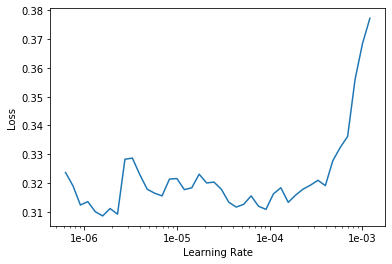

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12,slice(1e-06,1e-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.313527,0.272470,0.923156,01:01
1,0.329242,0.282285,0.921214,01:00
2,0.317261,0.324957,0.905520,01:01
3,0.299763,0.284140,0.921340,01:01
4,0.303555,0.290077,0.918079,01:01
5,0.288346,0.275214,0.922591,01:00
6,0.276524,0.288259,0.915996,01:01
7,0.268397,0.255418,0.926588,01:01
8,0.246142,0.265290,0.922968,01:01
9,0.237774,0.260842,0.925649,01:01


In [0]:
data.valid_ds

LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images

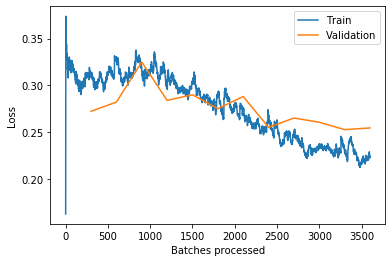

In [0]:
learn.recorder.plot_losses()

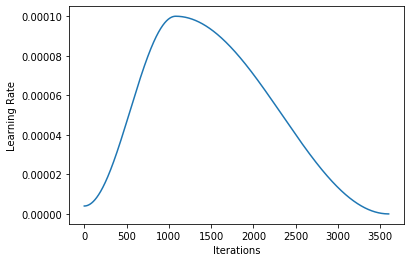

In [0]:
learn.recorder.plot_lr()

In [0]:
learn.save('seg-stage-2')

In [0]:
learn.load('seg-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480),Image (3, 360, 480)
y: SegmentationLabelList
ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480),ImageSegment (1, 360, 480)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [0]:
src_size=np.array(mask.shape[1:])
src_size
size=src_size;size
bs=1 #batch size

size

array([720, 960])

In [0]:

data = (SegmentationItemList.from_folder(path_img)
        #Where to find the data? -> in path_img and its subfolders
        .split_by_fname_file('/content/data/camvid/valid.txt')
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_fn, classes=codes)
        #How to label? -> use the label function on the file name of the data
        .transform(get_transforms(), tfm_y=True, size=size)
        #Data augmentation? -> use tfms with a size of 128, also transform the label images
        .databunch(bs=bs)
        .normalize(imagenet_stats))
        #Finally -> use the defaults for conversion to databunch

In [0]:
learn=unet_learner(data,models.resnet34,metrics=metrics)

In [0]:
learn.load('seg-stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [0]:
lr_find(learn)

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


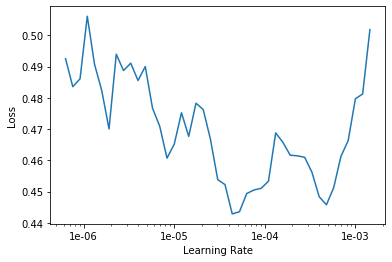

In [0]:
learn.recorder.plot()

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(10,slice(4e-05))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.371065,0.314293,0.914191,03:32
1,0.323639,0.284490,0.918932,03:32
2,0.315824,0.305609,0.912058,03:32
3,0.289008,0.277113,0.924120,03:32
4,0.255060,0.289289,0.916423,03:32
5,0.241116,0.266617,0.925334,03:32
6,0.227406,0.267922,0.924625,03:32
7,0.212772,0.259610,0.927050,03:32
8,0.214140,0.259813,0.926880,03:32
9,0.198917,0.269000,0.924593,03:32
